In [2]:
!pip install scikit-image mahotas opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.8 MB/s eta 0:00:00


In [3]:
!pip install opencv-python numpy pandas scikit-image mahotas matplotlib

In [10]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
import mahotas
from pathlib import Path
import matplotlib.pyplot as plt

class ProcesadorPapaNativa:
    def __init__(self):
        self.caracteristicas = []
        self.etiquetas = []
        self.nombres_imagenes = []
        self.imagenes_fallidas = []

    def visualizar_procesamiento(self, imagen, binaria, contorno, mascara):
        """
        Visualiza los pasos del procesamiento
        """
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))

        axes[0,0].imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
        axes[0,0].set_title('Imagen Original')

        axes[0,1].imshow(binaria, cmap='gray')
        axes[0,1].set_title('Segmentación')

        img_contorno = imagen.copy()
        cv2.drawContours(img_contorno, [contorno], -1, (0,255,0), 2)
        axes[1,0].imshow(cv2.cvtColor(img_contorno, cv2.COLOR_BGR2RGB))
        axes[1,0].set_title('Contorno Detectado')

        axes[1,1].imshow(mascara, cmap='gray')
        axes[1,1].set_title('Máscara')

        for ax in axes.flat:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    def preprocesar_imagen(self, imagen):
        """
        Preprocesa la imagen para mejorar la calidad
        """
        max_dim = 800
        height, width = imagen.shape[:2]
        if max(height, width) > max_dim:
            scale = max_dim / max(height, width)
            imagen = cv2.resize(imagen, None, fx=scale, fy=scale)

        imagen = cv2.GaussianBlur(imagen, (5, 5), 0)
        return imagen

    def extraer_caracteristicas_forma(self, contorno):
        """
        Extrae características de forma
        """
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)

        x, y, w, h = cv2.boundingRect(contorno)
        aspect_ratio = float(w)/h
        extent = float(area)/(w*h) if (w*h) > 0 else 0

        circularidad = 4 * np.pi * area / (perimetro * perimetro) if perimetro > 0 else 0

        momentos = cv2.moments(contorno)
        hu_moments = cv2.HuMoments(momentos).flatten()
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)

        return [area, perimetro, aspect_ratio, extent, circularidad] + list(hu_moments)

    def extraer_caracteristicas_color(self, imagen, mascara):
        """
        Extrae características de color
        """
        hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)

        caracteristicas_color = []

        for espacio in [imagen, hsv, lab]:
            for i in range(3):
                canal = espacio[:,:,i]
                pixels = canal[mascara > 0]

                if len(pixels) > 0:
                    caracteristicas_color.extend([
                        np.mean(pixels),
                        np.std(pixels),
                        np.percentile(pixels, 25),
                        np.percentile(pixels, 75)
                    ])
                else:
                    caracteristicas_color.extend([0, 0, 0, 0])

        return caracteristicas_color

    def extraer_caracteristicas_textura(self, imagen_gris, mascara):
        """
        Extrae características de textura (versión corregida)
        """
        roi = imagen_gris.copy()
        roi[mascara == 0] = 0

        # GLCM - reducimos a una sola distancia y cuatro ángulos
        distancias = [1]
        angulos = [0, np.pi/4, np.pi/2, 3*np.pi/4]

        glcm = graycomatrix(roi, distances=distancias, angles=angulos,
                           levels=256, symmetric=True, normed=True)

        # Reducimos a solo 5 propiedades GLCM
        propiedades = ['contrast', 'dissimilarity', 'homogeneity',
                      'energy', 'correlation']

        caracteristicas_glcm = []
        for prop in propiedades:
            # Tomamos la media sobre los ángulos para cada propiedad
            valor = graycoprops(glcm, prop).mean()
            caracteristicas_glcm.append(valor)

        # Haralick - tomamos solo las primeras 13 características
        haralick = mahotas.features.haralick(roi).mean(axis=0)[:13]

        # Combinamos GLCM (5) + Haralick (13) = 18 características de textura
        return list(caracteristicas_glcm) + list(haralick)

    def procesar_imagen(self, ruta_imagen, visualizar=False):
        """
        Procesa una imagen y extrae características
        """
        try:
            imagen = cv2.imread(ruta_imagen)
            if imagen is None:
                raise ValueError(f"No se pudo leer la imagen: {ruta_imagen}")

            imagen = self.preprocesar_imagen(imagen)

            gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
            _, binaria = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL,
                                          cv2.CHAIN_APPROX_SIMPLE)

            if not contornos:
                raise ValueError(f"No se encontraron contornos en: {ruta_imagen}")

            contorno = max(contornos, key=cv2.contourArea)

            mascara = np.zeros(gris.shape, dtype=np.uint8)
            cv2.drawContours(mascara, [contorno], -1, 255, -1)

            if visualizar:
                self.visualizar_procesamiento(imagen, binaria, contorno, mascara)

            caract_forma = self.extraer_caracteristicas_forma(contorno)
            caract_color = self.extraer_caracteristicas_color(imagen, mascara)
            caract_textura = self.extraer_caracteristicas_textura(gris, mascara)

            print(f"Características de forma: {len(caract_forma)}, color: {len(caract_color)}, textura: {len(caract_textura)}")

            return caract_forma + caract_color + caract_textura

        except Exception as e:
            print(f"Error procesando {ruta_imagen}: {str(e)}")
            self.imagenes_fallidas.append((ruta_imagen, str(e)))
            return None

    def procesar_dataset(self, directorio_base, visualizar_primeras=False):
        """
        Procesa todo el dataset de múltiples carpetas
        """
        print(f"Iniciando procesamiento del dataset en: {directorio_base}")
        total_procesadas = 0

        # Iterar sobre cada carpeta en el directorio base
        for carpeta in os.listdir(directorio_base):
            ruta_carpeta = os.path.join(directorio_base, carpeta)

            # Verificar si es un directorio
            if os.path.isdir(ruta_carpeta):
                print(f"Procesando carpeta: {carpeta}")
                for imagen_path in Path(ruta_carpeta).glob("*.jpg"):
                    print(f"Procesando imagen: {imagen_path.name}")
                    visualizar = visualizar_primeras and total_procesadas < 2

                    vector = self.procesar_imagen(str(imagen_path), visualizar)

                    if vector is not None:
                        expected_length = 66  # Esperado: 12 (forma) + 36 (color) + 18 (textura)

                        if len(vector) == expected_length:
                            self.caracteristicas.append(vector)
                            self.etiquetas.append(imagen_path.stem)
                            self.nombres_imagenes.append(imagen_path.name)
                            total_procesadas += 1
                        else:
                            print(f"Vector de características de tamaño inesperado para {imagen_path.name}: {len(vector)}")

                    if total_procesadas % 10 == 0 and total_procesadas > 0:
                        print(f"Procesadas {total_procesadas} imágenes...")

        print(f"Total de imágenes procesadas: {total_procesadas}")

        if not self.caracteristicas:
            print("No hay características para guardar.")
            return

        # Guardar características en un DataFrame
        nombres_columnas = (
            ['area', 'perimetro', 'aspect_ratio', 'extent', 'circularidad'] +
            [f'hu_moment_{i+1}' for i in range(7)] +
            ['media_r', 'std_r', 'percentil_25_r', 'percentil_75_r'] * 9 +  # 3 canales * 3 espacios de color
            [f'glcm_{prop}' for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']] +
            [f'haralick_{i+1}' for i in range(13)]
        )

        df_caracteristicas = pd.DataFrame(self.caracteristicas, columns=nombres_columnas)
        df_caracteristicas['etiqueta'] = self.etiquetas
        df_caracteristicas['nombre_imagen'] = self.nombres_imagenes

        df_caracteristicas.to_csv('caracteristicas_papa_nativa.csv', index=False)
        print("Características guardadas en 'caracteristicas_papa_nativa.csv'")


Iniciando procesamiento del dataset en: /content/drive/MyDrive/imagenes-Papas/imagenes/1
Procesando imagen: 1 (1).jpg


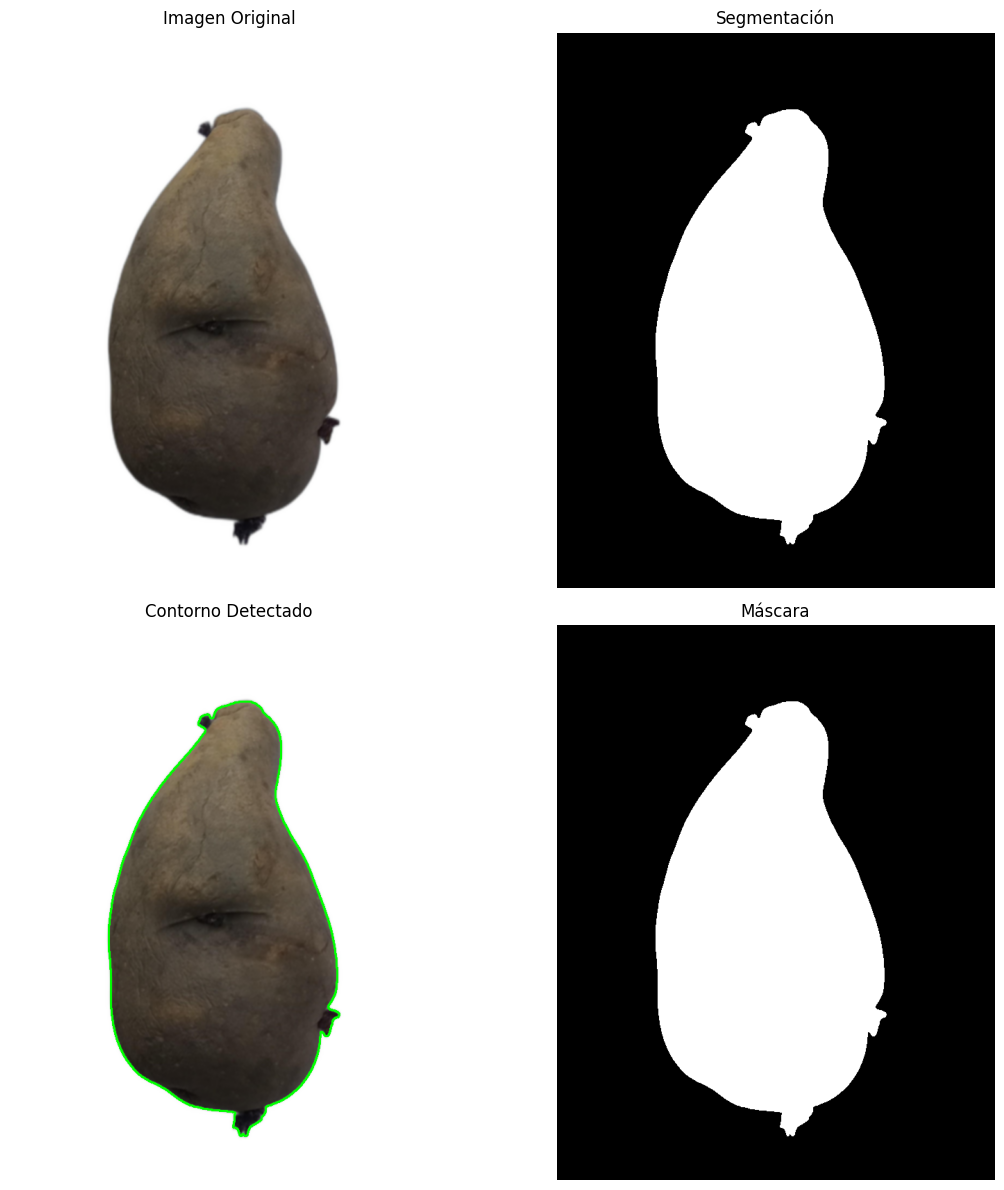

Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (2).jpg


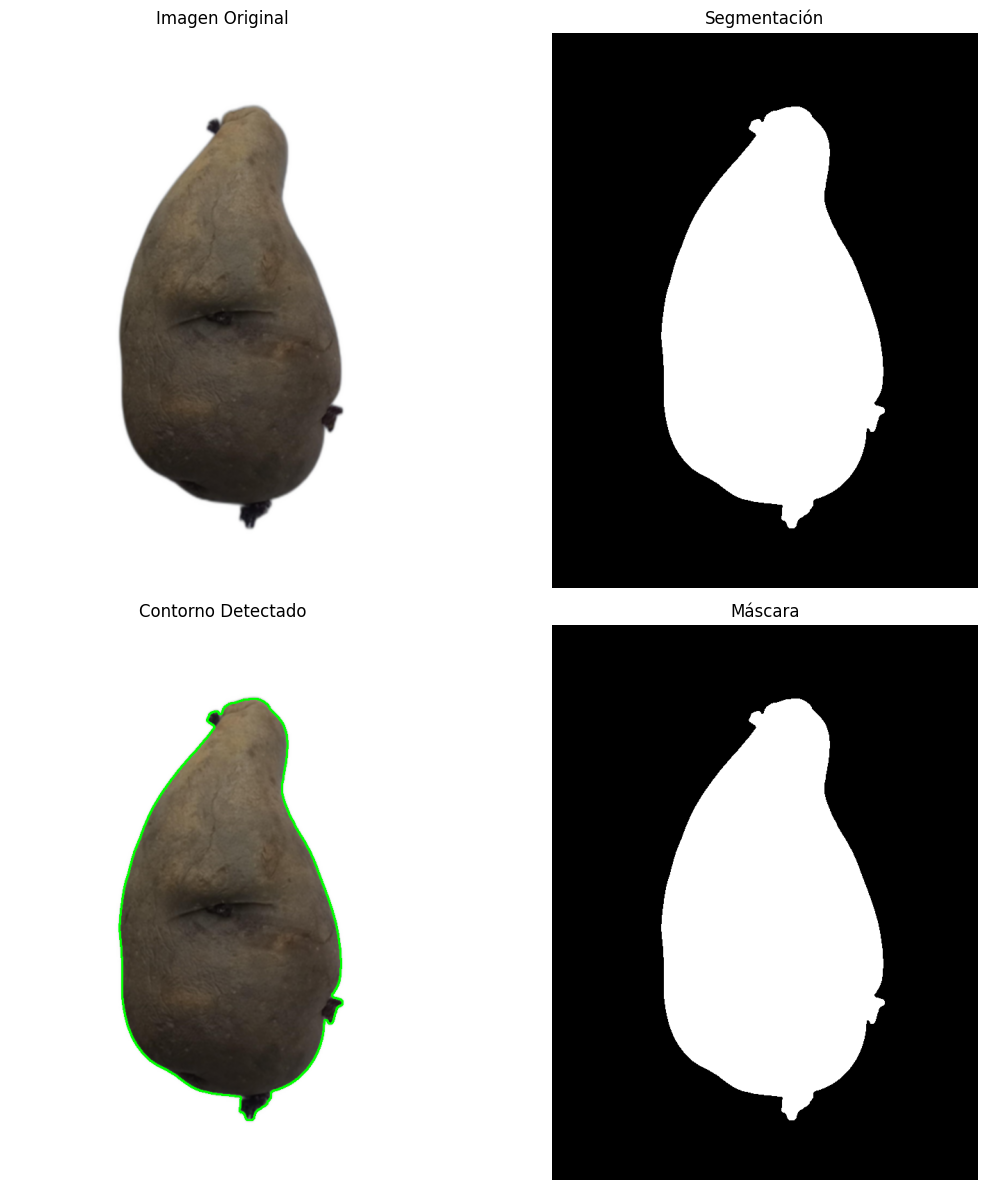

Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (3).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (4).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (5).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (6).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (7).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (8).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (9).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (10).jpg
Características de forma: 12, color: 36, textura: 18
Procesadas 10 imágenes...
Procesando imagen: 1 (11).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (12).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 1 (13).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imag

In [8]:
# Ejemplo de uso
if __name__ == "__main__":
    procesador = ProcesadorPapaNativa()
    procesador.procesar_dataset('/content/drive/MyDrive/imagenes-Papas/imagenes/1', visualizar_primeras=True)

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Iniciando procesamiento del dataset en: /content/drive/MyDrive/imagenes-Papas/imagenes/
Procesando carpeta: 79
Procesando imagen: 79 (1).jpg


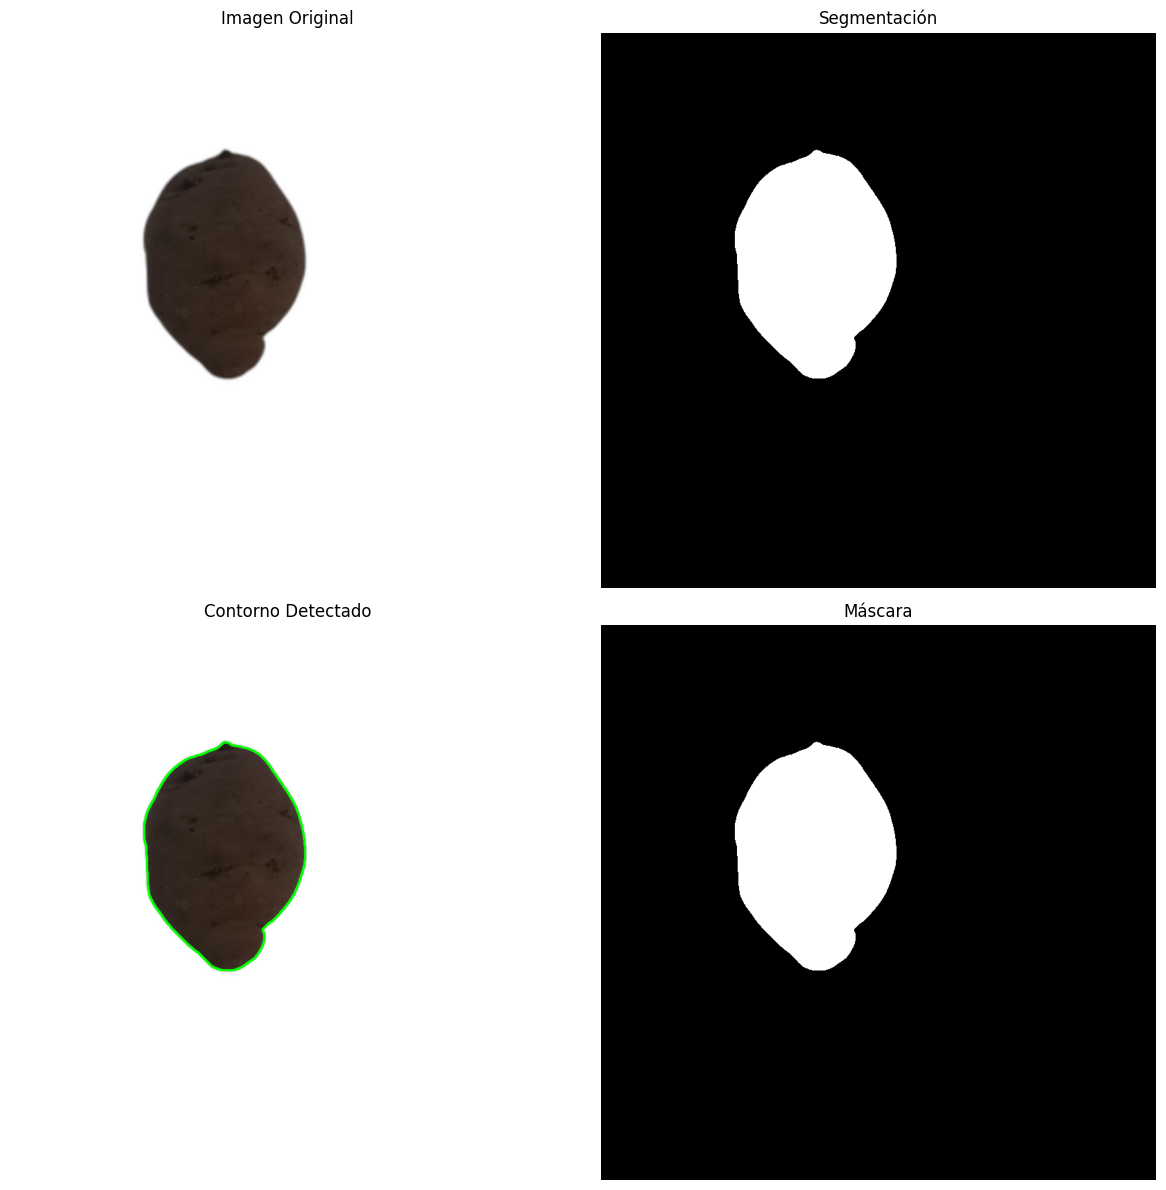

Características de forma: 12, color: 36, textura: 18
Procesando imagen: 79 (2).jpg


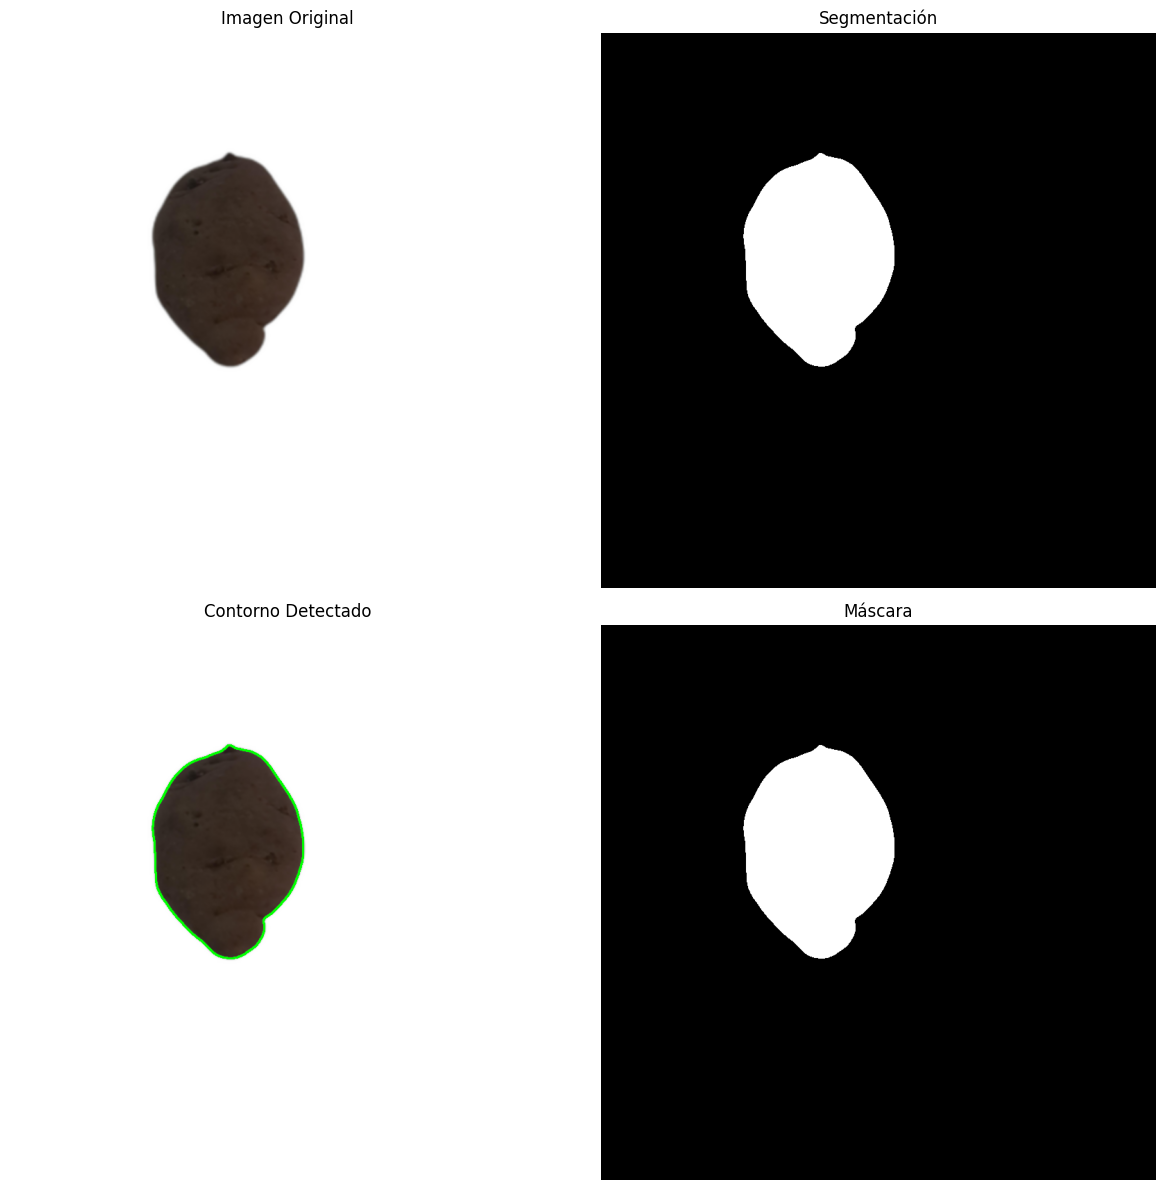

Se han truncado las últimas 5000 líneas del flujo de salida.
Características de forma: 12, color: 36, textura: 18
Procesando carpeta: 45
Procesando imagen: 45 (1).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 45 (2).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 45 (3).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 45 (4).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 45 (5).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 45 (6).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 45 (7).jpg
Características de forma: 12, color: 36, textura: 18
Procesadas 2370 imágenes...
Procesando imagen: 45 (8).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 45 (9).jpg
Características de forma: 12, color: 36, textura: 18
Procesando imagen: 45 (10).jpg
Características de forma: 12, color: 36, textura: 18
Proc

In [11]:
if __name__ == "__main__":
    # Montar Google Drive
    drive.mount('/content/drive')

    procesador = ProcesadorPapaNativa()

    # Ruta a la carpeta que contiene las subcarpetas
    ruta_base = '/content/drive/MyDrive/imagenes-Papas/imagenes/'

    # Procesar el dataset en la ruta base
    procesador.procesar_dataset(ruta_base, visualizar_primeras=True)